<a href="https://colab.research.google.com/github/OskarKrafft/Machine-Learning-Project/blob/main/notebooks/06_SHAP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Mounting to Google Drive
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/Colab Notebooks/Machine-Learning-Project

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Colab Notebooks/Machine-Learning-Project


In [3]:
# Change working directory to project folder
%cd /content/drive/MyDrive/Colab Notebooks/Machine-Learning-Project

/content/drive/MyDrive/Colab Notebooks/Machine-Learning-Project


## Import Test Data

In [4]:
# Importing the data
import pandas as pd
eppes_cleaned = pd.read_csv('./data/processed/eppes_cleaned.csv')
eppes_cleaned = eppes_cleaned.drop(eppes_cleaned.columns[0], axis = 1)

# Import Excel sheet containing column indeces to be dropped
columns_analysis = pd.read_excel('./data/interim/Drop_Columns_categorical.xlsx')
columns_analysis = columns_analysis.drop(columns_analysis.columns[[0]], axis = 1)

# Create list of names of categorical columns 
col_names_categorical = []
for i in range(872):
  if columns_analysis.iloc[i, 3] == 'categorical':
    col_names_categorical.append(columns_analysis.iloc[i, 1])

# Change datatype of categorical variables to object
eppes_cleaned[col_names_categorical] = eppes_cleaned[col_names_categorical].astype('object')

# Define X and y
print(eppes_cleaned.head())
X = eppes_cleaned.drop(columns='qg1') # reference variable which contains voted y/n
y = eppes_cleaned['qg1'] # reference variable which contains voted y/n

# 80/20 train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.20, random_state=123)

from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_test = label_encoder.fit_transform(y_test)

y_test_df = pd.DataFrame(data=y_test)
y_test_df.value_counts(normalize=True)

label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)

y_train_df = pd.DataFrame(data=y_train)
y_train_df.value_counts(normalize=True)

# Setting up pre-processing pipeline
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Identify all categorical variables by data type
categorical_X_features = X_test.select_dtypes(include=['object', 'bool']).columns

# OneHotEncode all categorical variables
categorical_transformer = OneHotEncoder(handle_unknown="error")

preprocessor = ColumnTransformer(remainder = 'passthrough', # remainder = passthrough for numerical variables to be kept unchanged
    transformers=[
        ("cat", categorical_transformer, categorical_X_features)]
)
# Inspect the number of variables after pre-processing

# Fit the pipeline to the testing data
preprocessor.fit(X_test)
X_test_ = preprocessor.transform(X_test)

# Fit the pipeline to the training data
preprocessor.fit(X_train)
X_train_ = preprocessor.transform(X_train)

   q1.1  q1.2  q1.3  q1.4  q1.5  q1.6  q1.7  q1.8  q1.9  q1.10  ...  d43a  \
0   1.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0    0.0  ...   2.0   
1   0.0   0.0   0.0   1.0   0.0   0.0   0.0   0.0   0.0    0.0  ...   2.0   
2   1.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0    0.0  ...   2.0   
3   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0    0.0  ...   1.0   
4   0.0   0.0   0.0   0.0   0.0   0.0   0.0   1.0   0.0    0.0  ...   2.0   

   d43b  d46.8  d60  d62_1  d62_2  d63  d72_1  d72_2  d77  
0   1.0    1.0  1.0    3.0    6.0  1.0    3.0    3.0  2.0  
1   1.0    1.0  3.0    2.0    6.0  3.0    2.0    2.0  3.0  
2   2.0    1.0  1.0    1.0    5.0  2.0    2.0    2.0  1.0  
3   1.0    1.0  2.0    1.0    1.0  3.0    2.0    2.0  1.0  
4   1.0    1.0  1.0    1.0    5.0  2.0    2.0    2.0  3.0  

[5 rows x 311 columns]


Import Models

In [5]:
from sklearn.ensemble import RandomForestClassifier

best_rf = RandomForestClassifier(max_depth = 10, n_estimators = 300, min_samples_split = 5, min_samples_leaf = 1, max_features = "sqrt", random_state = 123)

In [6]:
best_rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, max_features='sqrt', min_samples_split=5,
                       n_estimators=300, random_state=123)

In [7]:
y_pred_rf = best_rf.predict(X_test)

In [8]:
from sklearn.metrics import matthews_corrcoef, f1_score, accuracy_score, precision_score, recall_score
mcc = []
f1 = []

mcc.append((matthews_corrcoef(y_test, y_pred_rf)))
f1.append((f1_score(y_test, y_pred_rf)))

In [9]:

f1

[0.7846730528946271]

In [24]:
 pip install fasttreeshap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 286 kB 9.9 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 569 kB 39.8 MB/s 
  Created wheel for fasttreeshap: filename=fasttreeshap-0.1.3-cp37-cp37m-linux_x86_64.whl size=447262 sha256=5c8b3f64136d24918aaaf116d252bd2749ff8c492c81975a7da2c6ebdcf4e1b4
  Stored in directory: /root/.cache/pip/wheels/fa/eb/8f/fafe68d53fcd042bb115ca09eea3733575b1439ae3db22f2dc
Successfully built fasttreeshap


In [25]:
import fasttreeshap 

In [34]:
shap_explainer = fasttreeshap.TreeExplainer(best_rf, algorithm = "auto", n_jobs = -1)
shap_values = shap_explainer(X_test_)

In [39]:
shap_values

.values =
array([[[ 8.79976382e-05, -8.79976382e-05],
        [-4.74248597e-05,  4.74248597e-05],
        [ 1.12687306e-04, -1.12687306e-04],
        ...,
        [-4.32049866e-04,  4.32049866e-04],
        [ 1.35804007e-04, -1.35804007e-04],
        [-2.36490820e-04,  2.36490820e-04]],

       [[-1.42712944e-04,  1.42712944e-04],
        [-3.48694625e-05,  3.48694625e-05],
        [-1.69479101e-03,  1.69479101e-03],
        ...,
        [ 1.40735357e-04, -1.40735357e-04],
        [ 4.53887390e-04, -4.53887390e-04],
        [ 1.26860617e-05, -1.26860617e-05]],

       [[ 1.80315424e-03, -1.80315424e-03],
        [ 5.88295990e-04, -5.88295990e-04],
        [ 2.29729863e-04, -2.29729863e-04],
        ...,
        [ 1.37638011e-04, -1.37638011e-04],
        [ 2.94496013e-04, -2.94496013e-04],
        [ 8.78814619e-05, -8.78814619e-05]],

       ...,

       [[-1.17448360e-04,  1.17448360e-04],
        [ 4.55220529e-05, -4.55220529e-05],
        [ 2.22198461e-04, -2.22198461e-04],
        

In [13]:
import numpy
X_train = numpy.array(X_train,dtype='float64')

In [10]:
import shap

In [14]:
explainer = shap.Explainer(best_rf, X_train)
shap_test = explainer(X_test)
print(f"Shap values length: {len(shap_test)}\n")
print(f"Sample shap value:\n{shap_test[0]}")

100%|===================| 10978/10986 [13:26<00:00]       

Shap values length: 5493

Sample shap value:
.values =
array([[-1.22525403e-03,  1.22525400e-03],
       [-2.07659479e-04,  2.07659480e-04],
       [-7.27166776e-05,  7.27166736e-05],
       [-4.07604282e-04,  4.07604278e-04],
       [-1.54410544e-04,  1.54410540e-04],
       [ 5.35686881e-05, -5.35686927e-05],
       [-1.91737932e-04,  1.91737917e-04],
       [-4.48471234e-05,  4.48471204e-05],
       [-2.68036858e-05,  2.68036842e-05],
       [-5.67917644e-05,  5.67917633e-05],
       [ 3.13973075e-04, -3.13973095e-04],
       [-3.22099647e-05,  3.22099624e-05],
       [-4.65323167e-05,  4.65323099e-05],
       [-2.66541565e-04,  2.66541549e-04],
       [ 8.26243442e-05, -8.26243471e-05],
       [-2.67631253e-05,  2.67631200e-05],
       [ 1.50254757e-04, -1.50254769e-04],
       [-2.92927800e-05,  2.92927784e-05],
       [-6.14772834e-05,  6.14772804e-05],
       [ 9.00786243e-05, -9.00786325e-05],
       [-3.07784779e-04,  3.07784774e-04],
       [-2.15320795e-05,  2.15320816e-05],

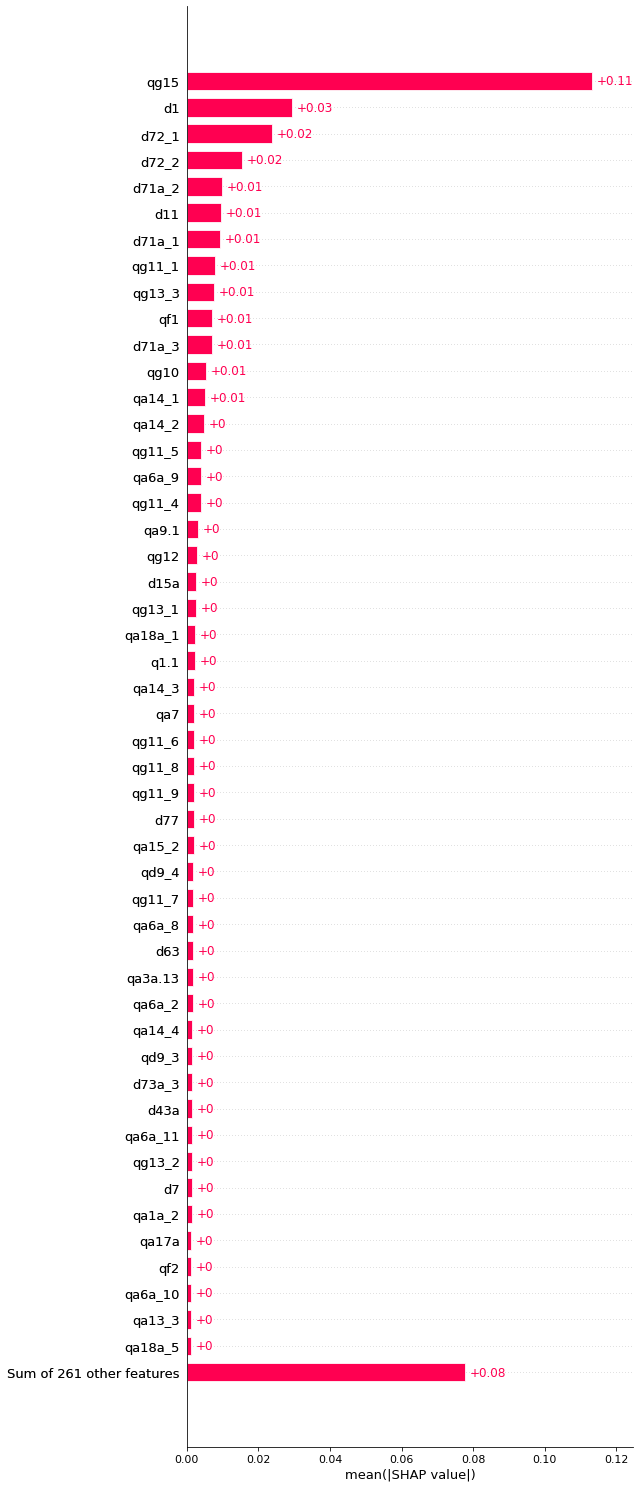

In [16]:
shap.plots.bar(shap_test[:, :, 1], max_display=50)